---
# Examples of 1-D function approximation using Multi-Layer Perceptrons
---

In this script, we show how a multi-layer perceptron (MLP) with a single hidden layer can be used, 
in a regression context, to fit a noisy 1-D signal.

This type of MLP can be an excellent function approximator ($y=f(x)$) when it is coupled with 
cross-validation to determine the number of neurons in its single hidden layer. 


In [1]:
print(__doc__)

# Author: Pierre Gravel <pierre.gravel@iid.ulaval.ca>
# License: BSD

import numpy as np

import matplotlib.pyplot as plt

from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_validate

import seaborn as sns
sns.set()

# Used for reproductibility of the results
np.random.seed(42)

Automatically created module for IPython interactive environment


## Generate the dataset
The (x,y) dataset is made of a noisy sinusoidal signal with some gaussian noise added. In many controled experiments, we select
equidistant values of the factor x and measure the corresponding response y. However, there are many instances where
the values of x are not distributed uniformly. This is the case, for instance, with epidemiological data where we look for 
a relationship between x and y data that were measured independently, at the same time.    


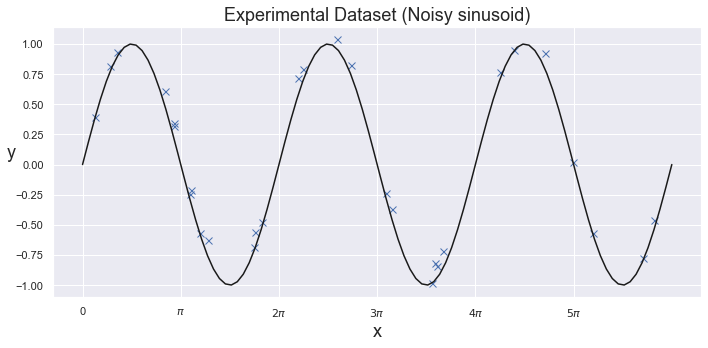

In [2]:
# Generate random and noisy observations in x and y
npts = 30
X = np.random.random_sample(npts) * 6*np.pi
y = np.sin(X) + 0.15*np.random.rand(npts)

# Sort the dataset in increasing values of X to avoid chaotic printing
indx = np.argsort(X)
X = X[indx] 
y = y[indx]

# Fine-grained version of noise-free signal
xx = np.linspace(0, 6*np.pi, num=100, endpoint=True).reshape(-1,1)
yy = np.sin(xx)


# Display clean and noisy signals
fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(X, y, 'x', markersize=7)
ax.plot(xx, yy, '-', color='k')
ax.set_xlabel('x',fontsize=18)
ax.set_ylabel('y',fontsize=18, rotation=0)

pos = np.arange(0, 6) * np.pi 
labels = ['0', '$\pi$', '$2\pi$', '$3\pi$', '$4\pi$', '$5\pi$', '$6\pi$']
ax.set_xticks(pos)
ax.set_xticklabels(labels)
ax.set_title('Experimental Dataset (Noisy sinusoid)',fontsize=18)
fig.tight_layout()

plt.savefig('7.1.1_Original_data.png')
plt.savefig('7.1.1_Original_data.pdf')

## Data normalisation

We want to train a MLP to predict the response y as a function of the factor X.
Better training results are obtained when the input data X is normalised. This regularization method eases the 
optimisation procedure, which leads to better fits to the data.

In [3]:
X = X.reshape(-1,1)
y = y.ravel()

mu = X.mean()
sigma = X.std()

# Normalized versions of the X data; we keep the original data for displaying purpose.
X_norm = (X-mu)/sigma
xx_norm = (xx-mu)/sigma

## Display prediction results for MLP with different numbers of neurons in the hidden layer.
The title over each panel indicates the structure of the MLP; 1-N-1 means one input, N neurons in the 
hidden layer and one output. 

Only one neuron is used in the first panel; we can see in it the shape of the logistic function (shifted and inverted). Of 
the three MLP used, the one with five neurons performs best but the fit is not very good in the second half
of the x range.

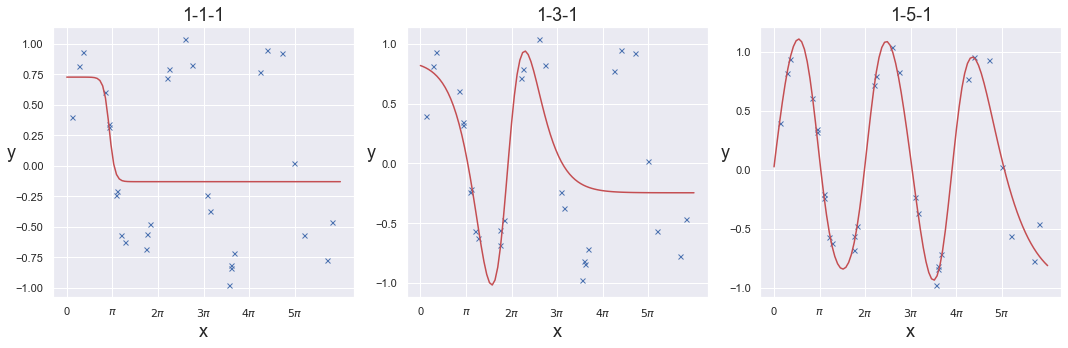

In [4]:
n_neurons = np.array([1, 3, 5])

fig, axs = plt.subplots(1,3, figsize=(15,5)) 
for k in range(3):
    # Define the MLP regressor for n neurons in the hidden layer
    regr = MLPRegressor(activation='logistic', solver='lbfgs', hidden_layer_sizes = (n_neurons[k],), 
                        random_state=1, max_iter=2500)
    
    # Train the regressor using normalized data
    regr.fit(X_norm, y)
    
    # Predict response using normalized inputs
    yy_p = regr.predict(xx_norm)

    # Show results without normalized data
    axs[k].plot(X, y, '.', marker='x', markersize=5)
    axs[k].plot(xx, yy_p, '-', color='r')
    axs[k].set_xlabel('x',fontsize=18)
    axs[k].set_ylabel('y',fontsize=18, rotation=0)
    axs[k].set_xticks(pos)
    axs[k].set_xticklabels(labels)
    axs[k].set_title('1-%d-1' % (n_neurons[k]),fontsize=18)
fig.tight_layout()

plt.savefig('7.1.2_Several_MLP_fits.png')
plt.savefig('7.1.2_Several_MLP_fits.pdf')

## Find the optimal number of neurons in the hidden layer
We use cross-validation to determine the optimal number of neurons. We vary the number of neurons in the hidden 
layer of several MLP and measure the RMS error between the predicted and true y data. The RMS error is obtained 
using a 10-fold cross-validation.

In [5]:
N = 15
rms_e = np.zeros([N,1])
n_neurons = np.arange(1,N+1)

for n in n_neurons:
    # Define the MLP regressor with n neurons in the hidden layer
    regr = MLPRegressor(activation='logistic', solver='lbfgs', hidden_layer_sizes = (n,), random_state=1, max_iter=2500)
    
    # Measure the RMS error between the data and the regression fit using cross validation with 10 folds
    cv_results = cross_validate(regr, X_norm, y,scoring='neg_mean_squared_error', cv=10)
    
    # Get the mean RMS value over the folds
    rms_e[n-1] = -cv_results['test_score'].mean()


## Show how the RMS error varies with the number of neurons in the hidden layer

Optimal number of neurons = 9


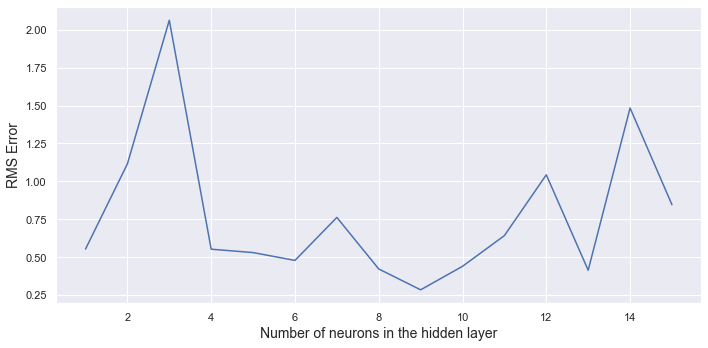

In [6]:
fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(n_neurons, rms_e, '-')
ax.set_xlabel('Number of neurons in the hidden layer',fontsize=14)
ax.set_ylabel('RMS Error',fontsize=14)
fig.tight_layout()

plt.savefig('7.1.3_MLP_fit_error_versus_number_of neurons.png')
plt.savefig('7.1.3_MLP_fit_error_versus_number_of neurons.pdf')

# Get the optimal number of neurons that minimises the RMS error
indx = np.argmin(rms_e)
n_opt = n_neurons[indx]
print('Optimal number of neurons = %d' % n_opt)


## Show the best regression results using the optimal MLP
The best MLP uses the optimal number of neurons in its hidden layer. The first panel in the next figure shows 
an excellent agreement between the MLP predictions and the actual y data. 

The second panel is even more interesting as it compares the MLP predictions with those from the model used 
to generate the data. Some discrepancies are obvious; whereas the black sinusoid varies between y=-1 and y=1, 
the red regression curve runs smoothly through the data points without being constrained by the [-1, +1] boundaries.

Hence, a good MLP fit should not replace a relevant theoretical model which parameters are adjusted to fit the data. 
A theoretical model makes important <i>a priori</i> information. However, when no theoretical model is available, 
the MLP can be an excellent function approximator when it is coupled with cross-validation for parameter optimisation. 

In [7]:
# Define the regressor of the optimal MLP
regr = MLPRegressor(activation='logistic', solver='lbfgs', hidden_layer_sizes = (n_opt,), random_state=1, max_iter=2500)

# Train the regressor using normalized data
regr.fit(X_norm, y)

# Predict response using normalized inputs
yy_p = regr.predict(xx_norm)

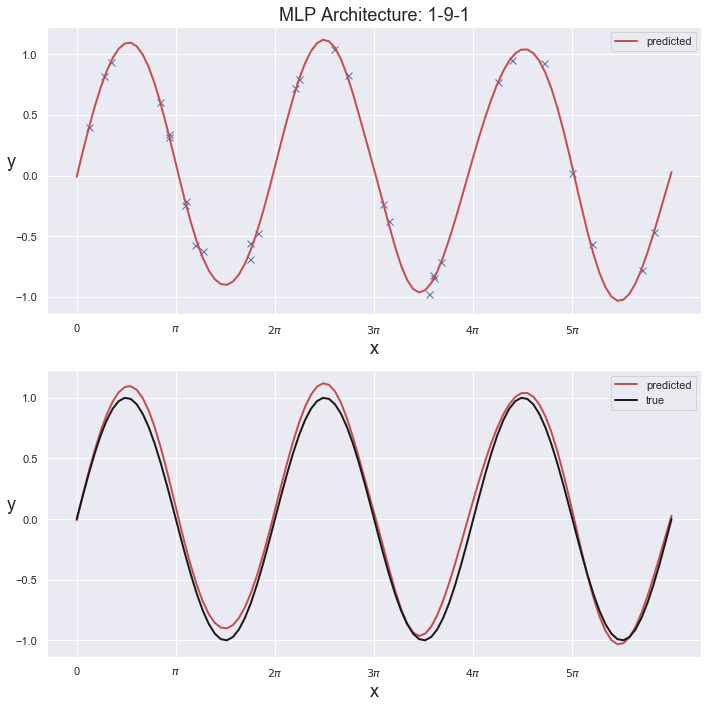

In [8]:
# Show best results without normalized data
fig, axs = plt.subplots(2, 1, figsize=(10, 10)) 

# Show fit to data
axs[0].plot(X, y, '.', marker='x', markersize=7)
axs[0].plot(xx, yy_p, '-', color='r', linewidth=2, label='predicted')
axs[0].set_xlabel('x',fontsize=18)
axs[0].set_ylabel('y',fontsize=18, rotation=0)
axs[0].set_xticks(pos)
axs[0].set_xticklabels(labels)
axs[0].legend()
axs[0].set_title('MLP Architecture: 1-%d-1' % (n_opt),fontsize=18)

# Show fit and model
axs[1].plot(xx, yy_p, '-', color='r', linewidth=2, label='predicted')
axs[1].plot(xx, yy, '-', color='k', linewidth=2, label='true')
axs[1].set_xlabel('x',fontsize=18)
axs[1].set_ylabel('y',fontsize=18, rotation=0)
axs[1].set_xticks(pos)
axs[1].set_xticklabels(labels)
axs[1].legend()
fig.tight_layout()


plt.savefig('7.1.4_Best_MLP_fit.png')
plt.savefig('7.1.4_Best_MLP_fit.pdf')